# 第三章 文档分割
 - [一、配置环境](#一、配置环境)
 - [二、文档分割重要性](#二、文档分割重要性)
 - [三、文档分割方式](#三、文档分割方式)
     - [3.1 基于字符的分割方式](#3.1-基于字符的分割方式)
     - [3.2 基于token的分割](#3.2-基于token的分割)
     - [3.3 分割Markdown文档](#3.3-分割Markdown文档)


我们刚刚讨论了如何将文档加载到标准格式中，现在我们要谈论如何将它们分割成较小的块。这听起来可能很简单，但其中有很多微妙之处会对后续工作产生重要影响。

## 一、配置环境

In [ ]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 

openai.api_key  = os.environ['OPENAI_API_KEY']

## 二、文档分割重要性
数据加载完毕后进行分割，分割完毕后放入向量数据库，进行向量化

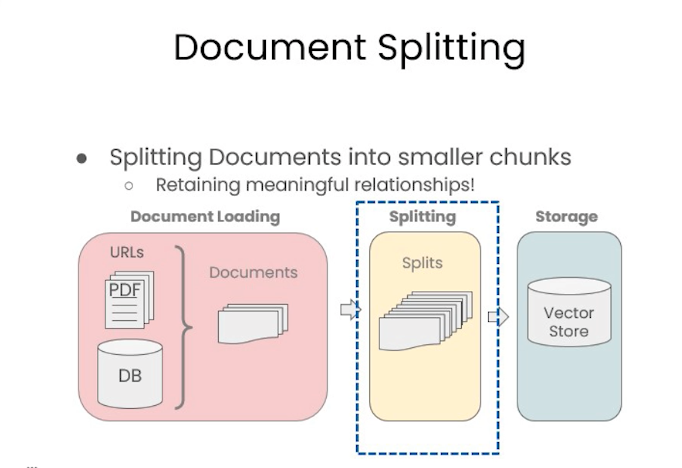

如果直接按照单个字符进行分割，会丢失文本的语义信息，从而导致无法正确的回答问题。因此，需要尽量保持语义的完整性，分割出具有语义的块。

## 三、文档分割方式
Langchain中文本分割器都根据chunk_size(块大小)和chunk_overlap(块与块之间的重叠大小)进行分割。

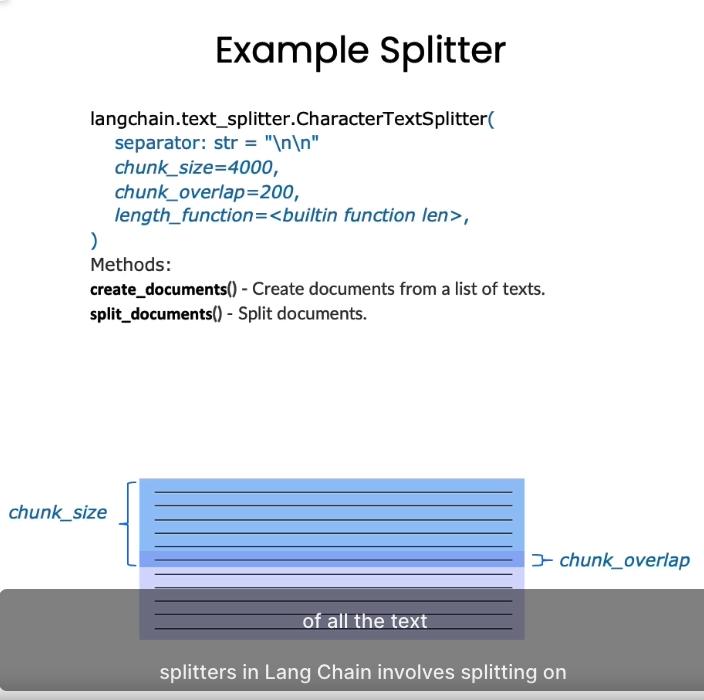

* chunk_size指每个块包含的字符或Token（如单词、句子等）的数量

* chunk_overlap指两个块之间共享的字符数量，用于保持上下文的连贯性，避免分割丢失上下文信息

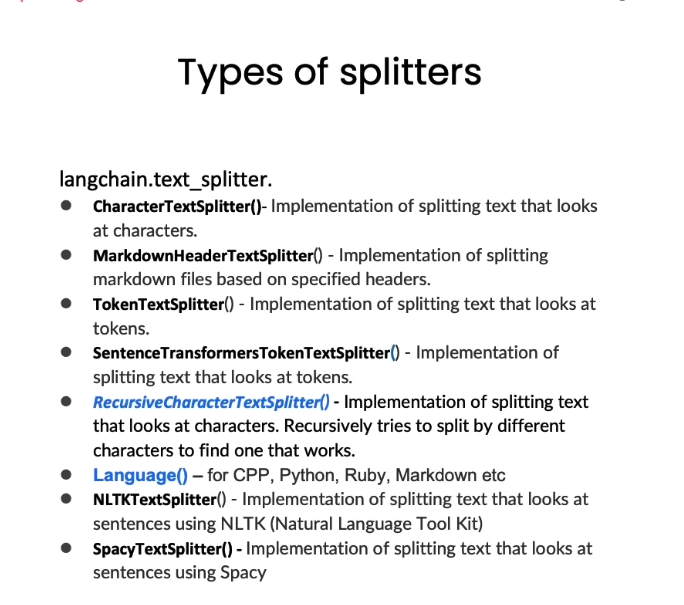

Langchain提供多种文档分割方式，区别在怎么确定块与块之间的边界、块由哪些字符/token组成、以及如何测量块大小

### 3.1 基于字符的分割方式
怎么分割块取决于我们的任务类型，当您拆分代码时，这一点非常明显。所以我们有一个语言文本分割器，它有一堆不同的分隔符，用于各种Python、Ruby、C 等不同语言的版本。在拆分这些文档时，考虑这些不同的语言的差异性。

In [12]:

''' 
* RecursiveCharacterTextSplitter 递归字符文本分割
* CharacterTextSplitter 字符分割
RecursiveCharacterTextSplitter 将按不同的字符递归地分割(按照这个优先级["\n\n", "\n", " ", ""])，这样就能尽量把所有和语义相关的内容尽可能长时间地保留在同一位置
RecursiveCharacterTextSplitter需要关注的是4个参数：

* separators - 分隔符字符串数组
* chunk_size - 每个文档的字符数量限制
* chunk_overlap - 两份文档重叠区域的长度
* length_function - 长度计算函数
CharacterTextSplitter 字符分割
分隔符的参数是单个的字符串。这就会使得RecursiveCharacterTextSplitter比CharacterTextSplitter对文档切割得更加碎片化
'''
#导入文本分割器
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter


In [13]:
chunk_size = 26 #设置块大小
chunk_overlap = 4 #设置块重叠大小


In [14]:
#初始化文本分割器
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)


In [15]:
#使用递归字符文本分割器
text2 = "abcdefghijklmnopqrstuvwxyzabcdefg"
r_splitter.split_text(text2)


['abcdefghijklmnopqrstuvwxyz', 'wxyzabcdefg']

In [18]:
text3 = "a b c d e f g h i j k l m n o p q r s t u v w x y z"#测试文本
r_splitter.split_text(text3)


['a b c d e f g h i j k l m', 'l m n o p q r s t u v w x', 'w x y z']

第二块是从'wxyz'开始的，刚好是我们设定的块重叠大小

In [19]:
#字符文本分割器
c_splitter.split_text(text3)


['a b c d e f g h i j k l m n o p q r s t u v w x y z']

可以看到字符分割器没有分割这个文本，因为字符文本分割器默认以换行符为分隔符，因此需要设置空格为分隔符。

In [21]:
# 设置空格分隔符
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separator=' '
)
c_splitter.split_text(text3)


['a b c d e f g h i j k l m', 'l m n o p q r s t u v w x', 'w x y z']

In [37]:
# 递归分割长段落
some_text1 = """When writing documents, writers will use document structure to group content. \
This can convey to the reader, which idea's are related. For example, closely related ideas \
are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n  \
Paragraphs are often delimited with a carriage return or two carriage returns. \
Carriage returns are the "backslash n" you see embedded in this string. \
Sentences have a period at the end, but also, have a space.\
and words are separated by space."""


In [38]:
len(some_text1)


496

In [39]:
# 中文版
some_text2 = """在编写文档时，作者将使用文档结构对内容进行分组。 \
    这可以向读者传达哪些想法是相关的。 例如，密切相关的想法\
    是在句子中。 类似的想法在段落中。 段落构成文档。 \n\n\
    段落通常用一个或两个回车符分隔。 \
    回车符是您在该字符串中看到的嵌入的“反斜杠 n”。 \
    句子末尾有一个句号，但也有一个空格。\
    并且单词之间用空格分隔"""


In [40]:
len(some_text2)


177

In [42]:
''' 
依次传入分隔符列表，分别是双换行符、单换行符、空格、空字符，
因此在分割文本时，首先会采用双分换行符进行分割，同时依次使用其他分隔符进行分割
'''

c_splitter = CharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separator=' '
)
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separators=["\n\n", "\n", " ", ""]
)


In [43]:
#分割结果
r_splitter.split_text(some_text1)


["When writing documents, writers will use document structure to group content. This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document.",
 'Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by space.']

In [44]:
r_splitter.split_text(some_text2)


['在编写文档时，作者将使用文档结构对内容进行分组。     这可以向读者传达哪些想法是相关的。 例如，密切相关的想法    是在句子中。 类似的想法在段落中。 段落构成文档。 \n\n    段落通常用一个或两个回车符分隔。     回车符是您在该字符串中看到的嵌入的“反斜杠 n”。     句子末尾有一个句号，但也有一个空格。    并且单词之间用空格分隔']

In [45]:
#如果需要按照句子进行分隔，则还要用正则表达式添加一个句号分隔符
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=0,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)
r_splitter.split_text(some_text1)


["When writing documents, writers will use document structure to group content. This can convey to the reader, which idea's are related.",
 'For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document.',
 'Paragraphs are often delimited with a carriage return or two carriage returns.',
 'Carriage returns are the "backslash n" you see embedded in this string.',
 'Sentences have a period at the end, but also, have a space.and words are separated by space.']

In [47]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=0,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)
r_splitter.split_text(some_text2)


['在编写文档时，作者将使用文档结构对内容进行分组。     这可以向读者传达哪些想法是相关的。 例如，密切相关的想法    是在句子中。 类似的想法在段落中。 段落构成文档。',
 '段落通常用一个或两个回车符分隔。     回车符是您在该字符串中看到的嵌入的“反斜杠 n”。     句子末尾有一个句号，但也有一个空格。    并且单词之间用空格分隔']

这就是递归字符文本分割器名字中“递归”的含义，总的来说，我们更建议在通用文本中使用递归字符文本分割器


### 3.2 基于token的分割
很多LLM的上下文窗口长度限制是按照Token来计数的。因此，以LLM的视角，按照Token对文本进行分隔，通常可以得到更好的结果。
通过一个实例理解基于字符分割和基于Token分割的区别

In [50]:
# 使用token分割器进行分割，
# 将块大小设为1，块重叠大小设为0，相当于将任意字符串分割成了单个Token组成的列
from langchain.text_splitter import TokenTextSplitter
text_splitter = TokenTextSplitter(chunk_size=1, chunk_overlap=0)
text1 = "foo bar bazzyfoo"
text_splitter.split_text(text1)


['foo', ' bar', ' b', 'az', 'zy', 'foo']

In [55]:
text1 = "test basecese"
text_splitter.split_text(text1)


['test', ' base', 'ces', 'e']

可以看出token长度和字符长度不一样，token通常为4个字符

### 3.3 分割Markdown文档
分块的目的是把具有上下文的文本放在一起，我们可以通过使用指定分隔符来进行分隔，但有些类型的文档（例如 Markdown）本身就具有可用于分割的结构（如标题）。

Markdown标题文本分割器会根据标题或子标题来分割一个Markdown文档，并将标题作为元数据添加到每个块中


In [58]:
# 定义一个Markdown文档

from langchain.document_loaders import NotionDirectoryLoader#Notion加载器
from langchain.text_splitter import MarkdownHeaderTextSplitter#markdown分割器

markdown_document = """# Title\n\n \
## Chapter 1\n\n \
Hi this is Jim\n\n Hi this is Joe\n\n \
### Section \n\n \
Hi this is Lance \n\n 
## Chapter 2\n\n \
Hi this is Molly"""


In [65]:
markdown_document = """# Title\n\n \
## 第一章\n\n \
李白乘舟将欲行\n\n 忽然岸上踏歌声\n\n \
### Section \n\n \
桃花潭水深千尺 \n\n 
## 第二章\n\n \
不及汪伦送我情"""


In [59]:
# 定义想要分割的标题列表和名称
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]


In [60]:
# 初始化Markdown标题文本分割器，分割Markdown文档
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)
md_header_splits = markdown_splitter.split_text(markdown_document)

md_header_splits[0]
# Document(page_content='Hi this is Jim  \nHi this is Joe', metadata={'Header 1': 'Title', 'Header 2': 'Chapter 1'})

md_header_splits[1]
# Document(page_content='Hi this is Lance', metadata={'Header 1': 'Title', 'Header 2': 'Chapter 1', 'Header 3': 'Section'})


Document(page_content='Hi this is Lance', metadata={'Header 1': 'Title', 'Header 2': 'Chapter 1', 'Header 3': 'Section'})

In [68]:
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)#分割文档
md_header_splits = markdown_splitter.split_text(markdown_document)
#第一个块
md_header_splits[0]
# Document(page_content='Hi this is Jim  \nHi this is Joe', metadata={'Header 1': 'Title', 'Header 2': 'Chapter 1'})




Document(page_content='李白乘舟将欲行  \n忽然岸上踏歌声  \n### Section  \n桃花潭水深千尺', metadata={'Header 1': 'Title', 'Header 2': '第一章'})

In [71]:
#第二个块
md_header_splits[1]


Document(page_content='不及汪伦送我情', metadata={'Header 1': 'Title', 'Header 2': '第二章'})

可以看到，每个块都包含了页面内容和元数据，元数据中记录了该块所属的标题和子标题。

我们已经了解了如何将长文档分割为语义相关的块，并且包含正确的元数据。下一步则是将这些分块后的数据移动到向量存储中，以便进行检索或生成

In [72]:
#加载数据库的内容
loader = NotionDirectoryLoader("docs/Notion_DB")
docs = loader.load()
txt = ' '.join([d.page_content for d in docs])#拼接文档


In [73]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]
#加载文档分割器
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)


In [74]:
md_header_splits = markdown_splitter.split_text(txt)#分割文本内容


In [75]:
md_header_splits[0]#分割结果


Document(page_content="Saying goodbye to Blendle (from a colleague) and to a colleague (from Blendle) is a very normal and natural thing. When done right, it can even be a beautiful thing.  \nWe advise you to read the backdrop below first, but feel free to jump in right away with the 'Here's what you can do'-section :). General note: you do not have to do this alone, so please ask for advice and help!  \n- **Backdrop**  \nSaying goodbye to Blendle (from a colleague) and to a colleague (from Blendle) is a very normal and natural thing. When done right, it can even be a beautiful thing.  \nSaying goodbye to people is also an important part of keeping your team on the right track. Firing can even be a part of your [Personnel Planning](https://www.notion.so/Hiring-451bbcfe8d9b49438c0633326bb7af0a?pvs=21). The most common situation will be when you think someone is no longer a good match with Blendle for whatever reason. This doesn't happen overnight, so try to spot situations where this is